In [19]:
import os
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np

In [2]:
marker1 = "Sac6"
marker2 = "Dad2"

pen_cols_to_select = ["Overall_Penetrance", "Overall_Small_Penetrance", "Overall_Large_Penetrance", "Overall_Elongated_Penetrance", "Overall_Nonpolar_Penetrance"]
renamed_marker1 = {col: f"{marker1}_{col}" for col in pen_cols_to_select}
renamed_marker2 = {col: f"{marker2}_{col}" for col in pen_cols_to_select}

pdf1 = pd.read_excel(f"/home/alex/alex_files/markerproject_redux/strain_filtering/Cells/filtered_strain_workbooks/{marker1}_filtered_strains.xlsx", sheet_name="SheetD")
marker1_pens = (
    pl
    .from_pandas(pdf1)
    .select(["ORF", "Name", "Strain_ID"] + pen_cols_to_select)
    .filter(~pl.col("ORF").is_in(["YOR202W", "YMR271C"]))
    .rename(renamed_marker1)
    )

pdf2 = pd.read_excel(f"/home/alex/alex_files/markerproject_redux/strain_filtering/Cells/filtered_strain_workbooks/{marker2}_filtered_strains.xlsx", sheet_name="SheetD")
marker2_pens = (
    pl
    .from_pandas(pdf2)
    .select(["ORF", "Name", "Strain_ID"] + pen_cols_to_select)
    .filter(~pl.col("ORF").is_in(["YOR202W", "YMR271C"]))
    .rename(renamed_marker2)
    )


joined_pens = (
    marker1_pens
    .join(marker2_pens, on=["ORF", "Strain_ID"])
)

In [5]:
joined_pens = (
    joined_pens
    .with_columns(
        (pl
        .when(pl.col(f"{marker1}_Overall_Penetrance").is_between(0, 25/100, closed="left"))
        .then(1)
        .when(pl.col(f"{marker1}_Overall_Penetrance").is_between(25/100, 50/100, closed="left"))
        .then(2)
        .when(pl.col(f"{marker1}_Overall_Penetrance").is_between(50/100, 75/100, closed="left"))
        .then(3)
        .when(pl.col(f"{marker1}_Overall_Penetrance").is_between(75/100, 100/100, closed="left"))
        .then(4)).alias(f"{marker1}_Bins"),
        (pl
        .when(pl.col(f"{marker2}_Overall_Penetrance").is_between(0, 25/100, closed="left"))
        .then(1)
        .when(pl.col(f"{marker2}_Overall_Penetrance").is_between(25/100, 50/100, closed="left"))
        .then(2)
        .when(pl.col(f"{marker2}_Overall_Penetrance").is_between(50/100, 75/100, closed="left"))
        .then(3)
        .when(pl.col(f"{marker2}_Overall_Penetrance").is_between(75/100, 100/100, closed="left"))
        .then(4)).alias(f"{marker2}_Bins")
    )
)

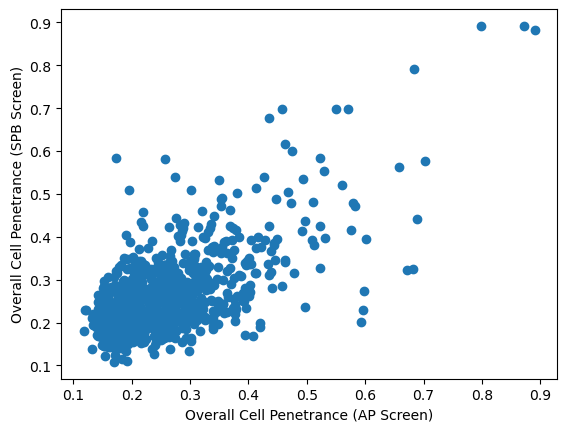

In [28]:
plt.scatter(
    x=joined_pens[f"{marker1}_Overall_Penetrance"],
    y=joined_pens[f"{marker2}_Overall_Penetrance"]
)

plt.xlabel(f"Overall Cell Penetrance (AP Screen)")
plt.ylabel(f"Overall Cell Penetrance (SPB Screen)")

plt.show()
plt.close()

In [ ]:
varx = joined_pens[f"{marker1}_Overall_Penetrance"].to_numpy()
vary = joined_pens[f"{marker2}_Overall_Penetrance"].to_numpy()

mask = ~np.isnan(varx) & ~np.isnan(vary)

linslope, intercept, r_value, p_value, std_err = \
    linregress(x=varx[mask], 
               y=vary[mask])

print(f"r value: {r_value}, r2 value: {r_value**2}, p value: {p_value}, num. values: {sum(mask)}")

### Comparing MPv1 and v2 Penetrances

In [28]:
mpv1_pens = (
    pl
    .read_csv("/mnt/c/Users/peree/OneDrive/Desktop/CompBio_Code/penetrance_pleiotropy_replicate_analysis/penetrance_data/aggregated_data/sheetD-b.csv")
    .filter(pl.col("Marker")=="Dad2")
    .select(["Strain", "Total_Penetrance"])
    .rename({"Total_Penetrance": "MPv1_Penetrance"}))

mpv2_pens = (
    pl
    .read_csv("/home/alex/alex_files/markerproject_redux/phenotypes/Dad2/cell_subcell_combined_pens.csv")
    .select(["Strain_ID", "Combined_Penetrance"])
    .with_columns(pl.col("Combined_Penetrance").cast(pl.Float32))
    .rename({"Strain_ID": "Strain", "Combined_Penetrance": "MPv2_Penetrance"}))

mpv1v2 = (
    mpv1_pens
    .join(mpv2_pens, on="Strain")
)

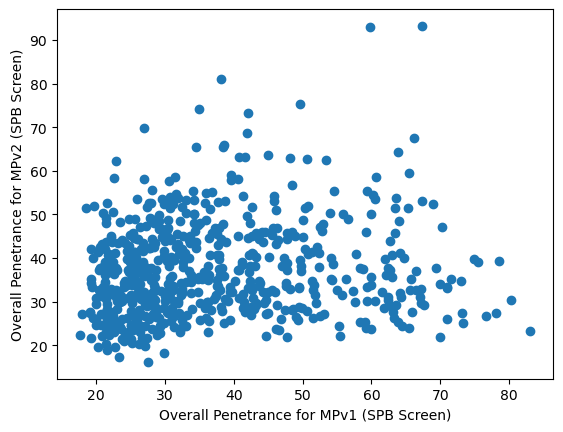

In [29]:
plt.scatter(
    x=mpv1v2["MPv1_Penetrance"],
    y=mpv1v2["MPv2_Penetrance"]
)

plt.xlabel(f"Overall Penetrance for MPv1 (SPB Screen)")
plt.ylabel(f"Overall Penetrance for MPv2 (SPB Screen)")

plt.show()
plt.close()

In [30]:
varx = mpv1v2["MPv1_Penetrance"].to_numpy()
vary = mpv1v2["MPv2_Penetrance"].to_numpy()

mask = ~np.isnan(varx) & ~np.isnan(vary)

linslope, intercept, r_value, p_value, std_err = \
    linregress(x=varx[mask], 
               y=vary[mask])
    
print(f"r value: {r_value}, r2 value: {r_value**2}, p value: {p_value}, num. values: {sum(mask)}")

r value: 0.12751301997248646, r2 value: 0.01625957026250373, p value: 0.001281684990403229, num. values: 635
